<a href="https://colab.research.google.com/github/benitomartin/multimodal-youtube-recipes/blob/main/youtube_recipes_multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Depencencies

In [ ]:
!pip install scrapetube pytube moviepy yt_dlp -q
!pip install git+https://github.com/openai/CLIP.git -q
!pip install llama-index-embeddings-clip -q
!pip install qdrant-client llama-index -q
!pip install llama-index-vector-stores-qdrant -q
!pip install llama-index-multi-modal-llms-gemini -q
!pip install llama-index-embeddings-gemini -q
!pip install llama-index-llms-gemini -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-llms-gemini 0.1.11 requires pillow<11.0.0,>=10.2.0, but you have pillow 10.0.1 which is incompatible.
llama-index-multi-modal-llms-gemini 0.1.7 requires pillow<11.0.0,>=10.2.0, but you have pillow 10.0.1 which is incompatible.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 6

# Import Libraries

In [ ]:
import os
import time
import scrapetube
import yt_dlp
import pandas as pd
from google.colab import userdata

from moviepy.editor import VideoFileClip

from qdrant_client import QdrantClient
from qdrant_client.http.models import VectorParams, Distance

from llama_index.core import SimpleDirectoryReader, StorageContext, Settings
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

import matplotlib.pyplot as plt
from PIL import Image

# Set Keys

In [ ]:
# Set KEYS
QDRANT_URL = userdata.get('QDRANT_URL')
QDRANT_API_KEY = userdata.get('QDRANT_API_KEY')
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# Create a DataFrame

In [ ]:
# Initialize lists to store data
vid_title_list = []
vid_description_list = []
url_list = []

# Get videos from the playlist
videos = scrapetube.get_playlist("PLpfv1AIjenVMmT7iRx6Nwu6uG6A9gSD0j")

# Extract all URLs
for video in videos:
    video_link = "https://www.youtube.com/watch?v=" + str(video['videoId'])
    url_list.append(video_link)

# Extract video details
for i in url_list[:3]:
    try:
        ydl_opts = {}
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info_dict = ydl.extract_info(i, download=False)
            vid_title = info_dict.get('title')
            vid_description = info_dict.get('description')

            vid_title_list.append(vid_title)
            vid_description_list.append(vid_description)
    except Exception as e:
        print(f"Error fetching details for {i}: {e}")
    time.sleep(1)  # Adding delay to avoid rate limiting

# Create the data dictionary
data = {
    "URL": url_list[:3],
    "Title": vid_title_list,
    "Description": vid_description_list
}

# Create the DataFrame
df = pd.DataFrame(data)

[youtube] Extracting URL: https://www.youtube.com/watch?v=aTWy_d_lkOk
[youtube] aTWy_d_lkOk: Downloading webpage
[youtube] aTWy_d_lkOk: Downloading ios player API JSON
[youtube] aTWy_d_lkOk: Downloading player 9ed4a7e1
[youtube] aTWy_d_lkOk: Downloading m3u8 information
[youtube] Extracting URL: https://www.youtube.com/watch?v=gVtUkvmKKU4
[youtube] gVtUkvmKKU4: Downloading webpage
[youtube] gVtUkvmKKU4: Downloading ios player API JSON
[youtube] gVtUkvmKKU4: Downloading player 8d9f6215
[youtube] gVtUkvmKKU4: Downloading m3u8 information
[youtube] Extracting URL: https://www.youtube.com/watch?v=-nXdN1cQM-s
[youtube] -nXdN1cQM-s: Downloading webpage
[youtube] -nXdN1cQM-s: Downloading ios player API JSON
[youtube] -nXdN1cQM-s: Downloading m3u8 information


In [ ]:
# Print the DataFrame
df.head()

,URL,Title,Description
0,https://www.youtube.com/watch?v=aTWy_d_lkOk,Kardea Brown's Lobster Tail Thermidor | Delici...,Kardea's take on this classic French dish is s...
1,https://www.youtube.com/watch?v=gVtUkvmKKU4,Katie Lee Biegel's Slow Cooker Pulled Pork Tac...,"Katie's family loves a slow cooker recipe, and..."
2,https://www.youtube.com/watch?v=-nXdN1cQM-s,Food Network Chefs' Top Ice Cream Recipe Video...,Create the perfect ice cream dish for the summ...


# Save Recipes as Text

In [ ]:
# Define the output folder
output_folder = 'output_folder'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through each row in the dataframe
for index, row in df.iterrows():
    # Define the file name and path
    file_name = f"Recipe {row['Title']}.txt"
    file_path = os.path.join(output_folder, file_name)

    # Write the description to the text file
    with open(file_path, 'w') as file:
        file.write(row['Description'])

print("Files have been saved successfully.")

Files have been saved successfully.


# Save Images Frames from Videos

In [ ]:
# Create directories for downloads and save images with recipes
download_folder = 'downloaded_videos'

os.makedirs(download_folder, exist_ok=True)

# Function to download a video
def download_video(url, output_path):
    ydl_opts = {
        'outtmpl': output_path
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

# Function to check if images already exist for a video
def images_exist(title):
    return any(fname.startswith(title) for fname in os.listdir(output_folder))

# Iterate over the URLs in the dataframe and download each video
for idx, row in df.iterrows():
    url = row['URL']
    title = row['Title']
    video_filename = os.path.join(download_folder, f"{title}.mp4.webm")

    try:
        # Check if the video already exists
        if not os.path.exists(video_filename):
            download_video(url, video_filename)
            print(f"Downloaded {title}")
        else:
            print(f"Video {title} already exists. Skipping download.")

        # Check if images already exist
        if not images_exist(title):
            # Load the video and save frames as images
            clip = VideoFileClip(video_filename)
            clip.write_images_sequence(os.path.join(output_folder, f"{title}_frame_%04d.png"), fps=0.03)
            print(f"Images saved for {title}")
        else:
            print(f"Images for {title} already exist. Skipping image extraction.")

    except Exception as e:
        print(f"Error processing {title}: {e}")

print("Process completed.")

[youtube] Extracting URL: https://www.youtube.com/watch?v=aTWy_d_lkOk
[youtube] aTWy_d_lkOk: Downloading webpage
[youtube] aTWy_d_lkOk: Downloading ios player API JSON
[youtube] aTWy_d_lkOk: Downloading m3u8 information
[info] aTWy_d_lkOk: Downloading 1 format(s): 616+251
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 57
[download] Destination: downloaded_videos/Kardea Brown's Lobster Tail Thermidor | Delicious Miss Brown | Food Network.mp4.f616.mp4
[download] 100% of   97.47MiB in 00:00:06 at 15.17MiB/s                
[download] Destination: downloaded_videos/Kardea Brown's Lobster Tail Thermidor | Delicious Miss Brown | Food Network.mp4.f251.webm
[download] 100% of    4.20MiB in 00:00:00 at 19.80MiB/s  
[Merger] Merging formats into "downloaded_videos/Kardea Brown's Lobster Tail Thermidor | Delicious Miss Brown | Food Network.mp4.webm"
Deleting original file downloaded_videos/Kardea Brown's Lobster Tail Thermidor | Delicious Miss Brown | Food Network.mp4.f251.web

Moviepy - Done writing frames output_folder/Kardea Brown's Lobster Tail Thermidor | Delicious Miss Brown | Food Network_frame_%04d.png.
Images saved for Kardea Brown's Lobster Tail Thermidor | Delicious Miss Brown | Food Network
[youtube] Extracting URL: https://www.youtube.com/watch?v=gVtUkvmKKU4
[youtube] gVtUkvmKKU4: Downloading webpage


[youtube] gVtUkvmKKU4: Downloading ios player API JSON
[youtube] gVtUkvmKKU4: Downloading m3u8 information
[info] gVtUkvmKKU4: Downloading 1 format(s): 616+251
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 125
[download] Destination: downloaded_videos/Katie Lee Biegel's Slow Cooker Pulled Pork Tacos | The Kitchen | Food Network.mp4.f616.mp4
[download] 100% of  358.21MiB in 00:00:20 at 17.15MiB/s                  
[download] Destination: downloaded_videos/Katie Lee Biegel's Slow Cooker Pulled Pork Tacos | The Kitchen | Food Network.mp4.f251.webm
[download] 100% of    8.55MiB in 00:00:00 at 35.97MiB/s  
[Merger] Merging formats into "downloaded_videos/Katie Lee Biegel's Slow Cooker Pulled Pork Tacos | The Kitchen | Food Network.mp4.webm"
Deleting original file downloaded_videos/Katie Lee Biegel's Slow Cooker Pulled Pork Tacos | The Kitchen | Food Network.mp4.f616.mp4 (pass -k to keep)
Deleting original file downloaded_videos/Katie Lee Biegel's Slow Cooker Pulled Pork

Moviepy - Done writing frames output_folder/Katie Lee Biegel's Slow Cooker Pulled Pork Tacos | The Kitchen | Food Network_frame_%04d.png.
Images saved for Katie Lee Biegel's Slow Cooker Pulled Pork Tacos | The Kitchen | Food Network
[youtube] Extracting URL: https://www.youtube.com/watch?v=-nXdN1cQM-s
[youtube] -nXdN1cQM-s: Downloading webpage


[youtube] -nXdN1cQM-s: Downloading ios player API JSON
[youtube] -nXdN1cQM-s: Downloading m3u8 information
[info] -nXdN1cQM-s: Downloading 1 format(s): 616+251
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 390
[download] Destination: downloaded_videos/Food Network Chefs' Top Ice Cream Recipe Videos | Food Network.mp4.f616.mp4
[download] 100% of  749.69MiB in 00:00:51 at 14.58MiB/s                  
[download] Destination: downloaded_videos/Food Network Chefs' Top Ice Cream Recipe Videos | Food Network.mp4.f251.webm
[download] 100% of   26.91MiB in 00:00:00 at 55.21MiB/s  
[Merger] Merging formats into "downloaded_videos/Food Network Chefs' Top Ice Cream Recipe Videos | Food Network.mp4.webm"
Deleting original file downloaded_videos/Food Network Chefs' Top Ice Cream Recipe Videos | Food Network.mp4.f616.mp4 (pass -k to keep)
Deleting original file downloaded_videos/Food Network Chefs' Top Ice Cream Recipe Videos | Food Network.mp4.f251.webm (pass -k to keep)
Downloa

Moviepy - Done writing frames output_folder/Food Network Chefs' Top Ice Cream Recipe Videos | Food Network_frame_%04d.png.
Images saved for Food Network Chefs' Top Ice Cream Recipe Videos | Food Network
Process completed.


# Create Collections and VectorStore

In [ ]:
# Initialize Qdrant client
client = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)

In [ ]:
# Create a collection for text data
client.create_collection(
    collection_name="text_collection",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE)
)

# Create a collection for image data
client.create_collection(
    collection_name="image_collection",
    vectors_config=VectorParams(size=512, distance=Distance.COSINE)
)

True

In [ ]:
# Initialize Collections
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)

image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

In [ ]:
# Set Global settings
embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY)

llm = GeminiMultiModal(
    model_name="models/gemini-pro-vision", api_key=GOOGLE_API_KEY)

Settings.llm = llm
Settings.embed_model = embed_model

In [ ]:
# Create the MultiModal index

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

documents = SimpleDirectoryReader("/content/output_folder").load_data()

index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context)

In [57]:
# Initialize index from vector store
index = MultiModalVectorStoreIndex.from_vector_store(
    text_store,
    image_vector_store=image_store)

# Retrieve Results

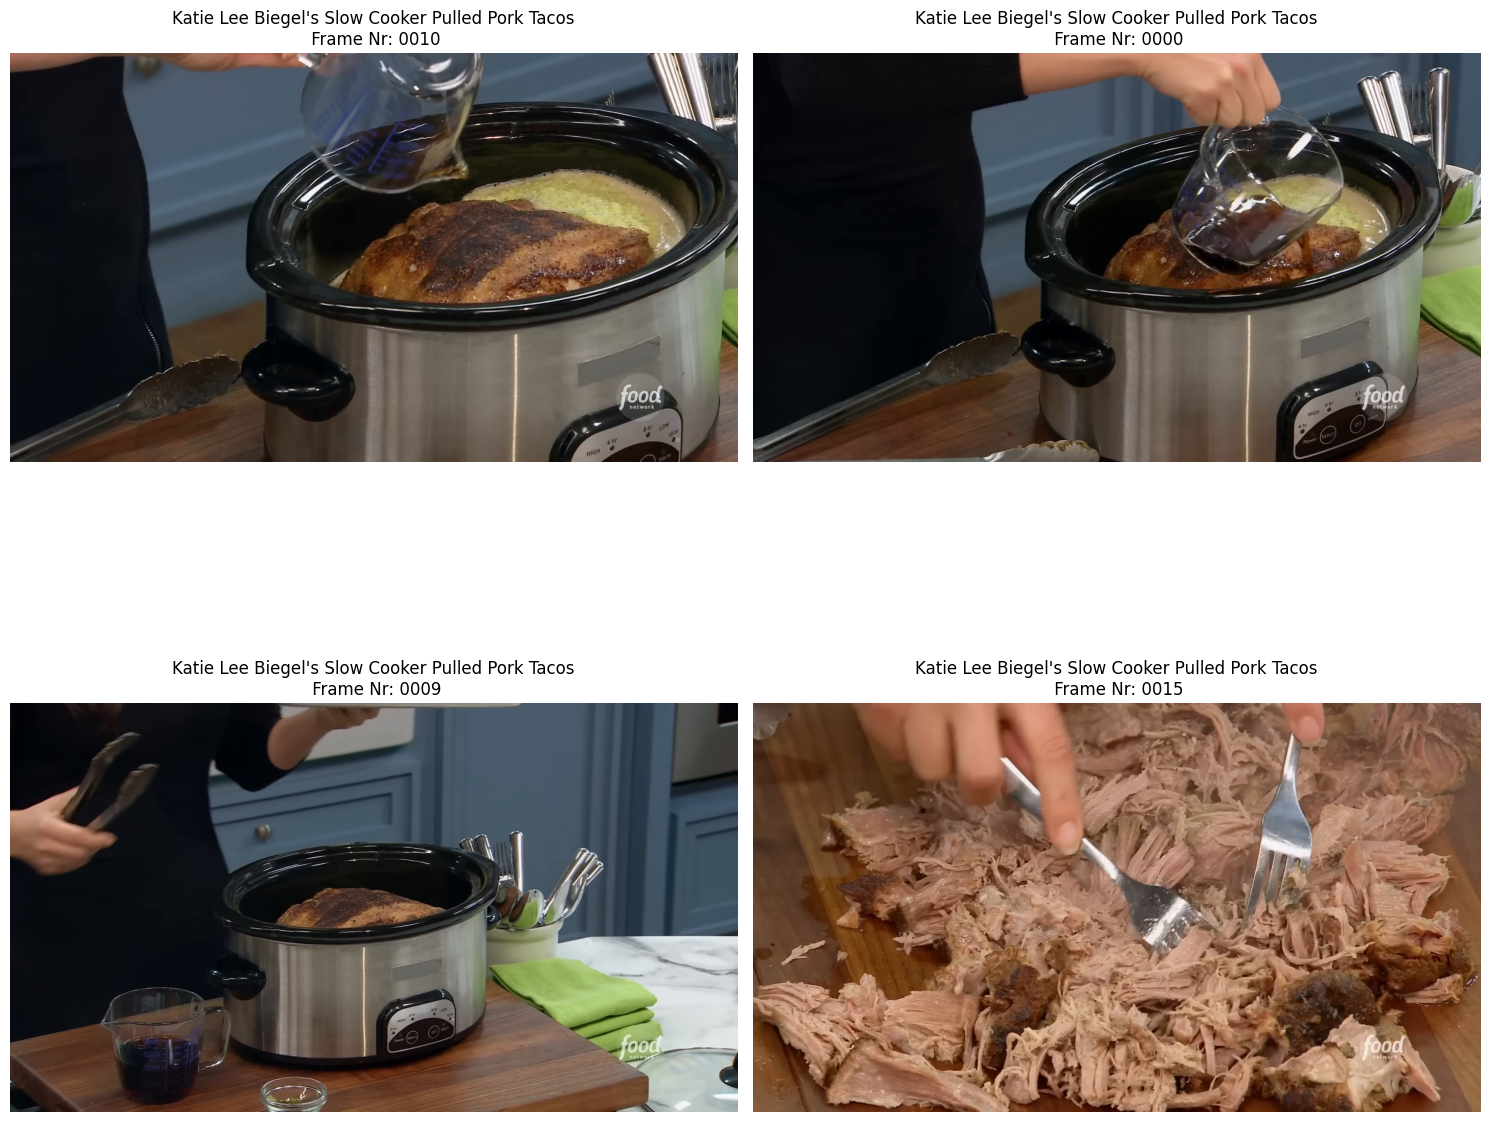

---------------------
THIS IS THE RECIPE
---------------------
Katie's family loves a slow cooker recipe, and her husband especially loves one that involves pulled pork. This recipe takes inspiration from al pastor and carnitas made with cola. Katie says the house smells wonderful with this pork simmering away all day! 
#FoodNetwork #KatieLee #TheKitchen #SlowCooker #PulledPork 
Watch Katie on #TheKitchen, Saturdays at 11a|10c and #StreamOnMax: https://foodtv.com/StreamOnMaxYT!
Get the recipe ► https://foodtv.com/3RRfgjk
Subscribe to Food Network's YouTube ► https://foodtv.com/3wzBjU0

Talented food experts gather in the kitchen to share lively conversation and delicious recipes. From simple supper ideas to the latest food trends, they cover all things fun in food!

Welcome to Food Network, where learning to cook is as simple as clicking play! Grab your apron and get ready to get cookin' with some of the best chefs around the world. We'll give you a behind-the-scenes look at our best s

In [70]:
# Function to retrieve the results, text and images

def show_retrieval_results(retrieval_results):


    # Plot the images in a 2x2 grid (2 rows, 2 columns)
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    axs = axs.flatten()  # Flatten the 2D array of axes for easy iteration

    for i in range(1, 5):
        if i < len(retrieval_results):  # Check if index is within the range of retrieval_results
            file_path = retrieval_results[i].metadata['file_path']
            file_name_to_search = retrieval_results[i].metadata['file_name']

            # Extract the frame identifier from the file name
            title_part = file_name_to_search.split('|')[0].strip()
            frame_part = file_name_to_search.split('_')[-1].split('.')[0]


            # Load the image using PIL
            image = Image.open(file_path)

            # Display the image using Matplotlib
            axs[i-1].imshow(image)
            axs[i-1].axis('off')
            axs[i-1].set_title(f"{title_part}\n Frame Nr: {frame_part}")
        else:
            axs[i-1].axis('off')  # Hide unused subplot axes

    plt.tight_layout()
    plt.show()

    # Display the Recipe
    print("---------------------")
    print("THIS IS THE RECIPE")
    print("---------------------")
    print(retrieval_results[0].text)

# Set query and retriever
query = "Could you provide me a recipe of Slow Cooker Pulled Pork Tacos?"
retriever = index.as_retriever(similarity_top_k=1, image_similarity_top_k=4)  # Adjust to retrieve enough images
retrieval_results = retriever.retrieve(query)

# Call the function with the retrieval results
show_retrieval_results(retrieval_results)